In [ ]:
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm_notebook as tqdm
import numpy as np



In [ ]:
drive.mount("/content/gdrive")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
path = "/content/gdrive/MyDrive/aptos2019-blindness-detection/"
df = pd.read_csv(path+"train.csv", sep=",")
train_images = os.listdir(path + "train_images")

In [ ]:
img_list = []

In [ ]:

for i in tqdm(train_images[:500]):
  img = cv2.imread(path + "train_images/"+ i)
  img = cv2.resize(img, (400,400))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  copy = img.copy()
  copy = cv2.cvtColor(copy, cv2.COLOR_RGB2GRAY)
  blurred = cv2.GaussianBlur(copy,(5,5), 0)
  thresh = cv2.threshold(blurred, 18, 255, cv2.THRESH_BINARY)[1]
  contour = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  contour = contour[0][0]
  contour = contour[:,0,:]
  x1 = tuple(contour[contour[:,0].argmin()])[0]
  y1 = tuple(contour[contour[:,1].argmin()])[1]
  x2 = tuple(contour[contour[:,0].argmax()])[0]
  y2 = tuple(contour[contour[:,1].argmax()])[1]
  x = int(x2-x1)*4//100
  y = int(y2-y1)*5//100
  copy_2 = img.copy()
  if x2-x1 > 100 and y2-y1 > 100:
    copy_2 = copy_2[y1+y:y2-y, x1+x:x2-x]
    copy_2 = cv2.resize(copy_2, (400,400))
  lab = cv2.cvtColor(copy_2, cv2.COLOR_RGB2LAB)
  l, a, b = cv2.split(lab)
  clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=((8,8)))
  cl = clahe.apply(l)
  l_img = cv2.merge((cl, a, b))
  last = cv2.cvtColor(l_img, cv2.COLOR_LAB2RGB)
  med_last = cv2.medianBlur(last, 3)
  background = cv2.medianBlur(last, 37)
  mask = cv2.addWeighted(med_last,1, background,-1,255)
  final_img = cv2.bitwise_and(mask, med_last)
  img_list.append(final_img)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/500 [00:00<?, ?it/s]

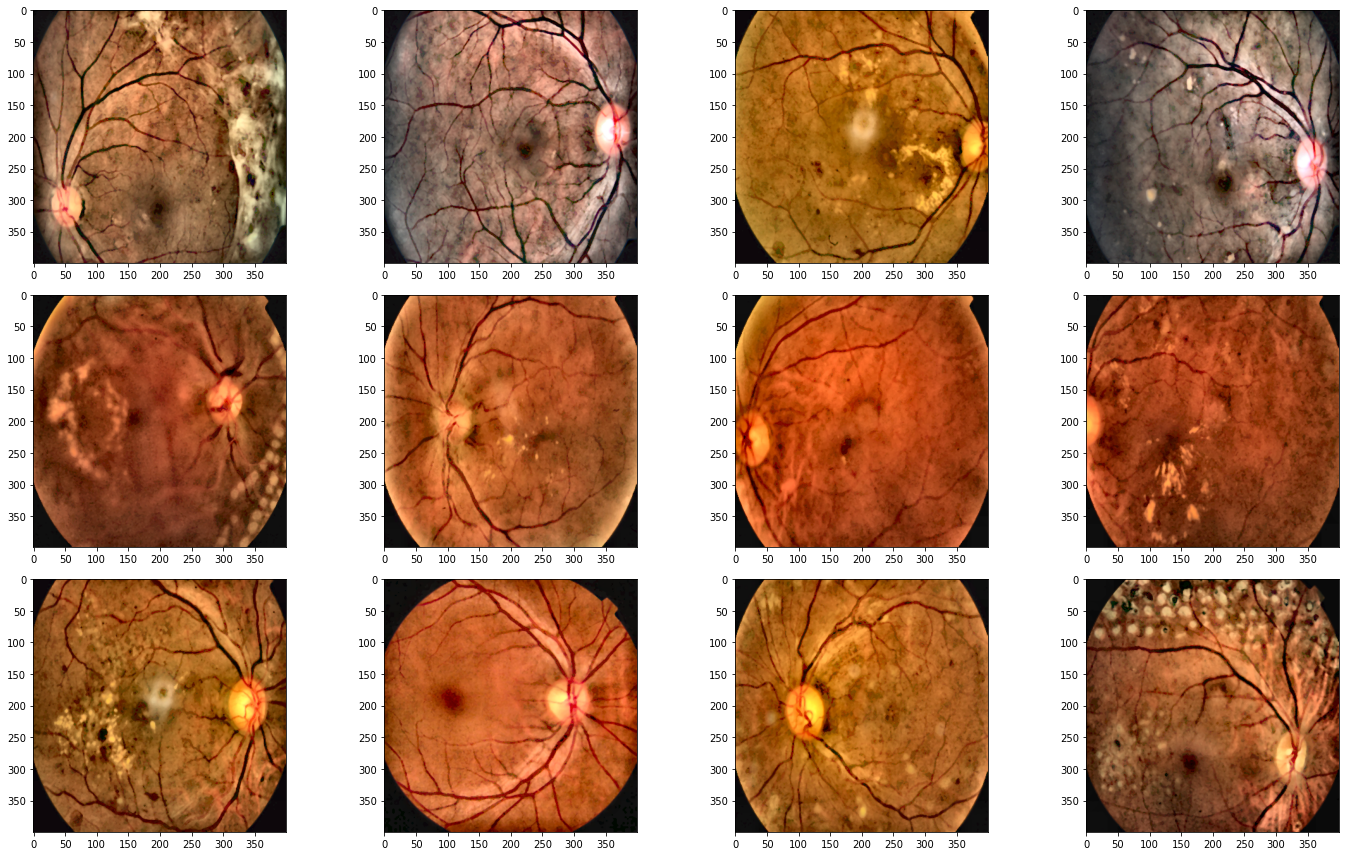

In [ ]:
fig = plt.figure(figsize=(20,12))
for i in range (12):
  img = img_list[i]
  fig.add_subplot(3, 4, i+1)
  plt.imshow(img)

plt.tight_layout()

In [ ]:
y_train = pd.get_dummies(df["diagnosis"]).values
y_train_last = np.ones(y_train.shape, dtype="uint8")
y_train_last[:,4] = y_train[:,4]
for i in range(3, -1, -1):
  y_train_last[:,i] = np.logical_or(y_train[:,i], y_train_last[:,i+1])

In [ ]:
# list2array
x_train = np.array(img_list)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train,
    y_train_last[:500],
    test_size = 0.15,
    random_state = 2019,
    shuffle = True
)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)

In [ ]:
data_generator = datagen.flow(x_train, y_train, batch_size=2, seed=2020)

In [ ]:
# transfer learning
# EfficientNet - B5 Model
!pip install efficientnet
!pip install tensorflow==2.6.0
!pip install keras~=2.6.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     | 564.4 MB 70.7 MB/s
     |████████████████████████████████| 132 kB 7.4 MB/s 
     |████████████████████████████████| 14.8 MB 45.2 MB/s 
  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30694 sha256=9a870f2648c109f9eafbff078be87ac9f1cece36eed320fc07596a17478eea5d
  Stored in directory: /root/.cache/pip/wheels/98/91/04/971b4c587cf47ae952b108949b46926f426c02832d120a082a
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68727 sha256=bf19eb81b54edd213685bea52f666e596e3a350d38b781a65cd96e535b0737ee
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built clang wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.2.0
    Uninst

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 7.4 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0


In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf


In [ ]:
model = tf.keras.applications.efficientnet.EfficientNetB5()
model_2 = tf.keras.applications.efficientnet.EfficientNetB5(include_top=False, input_shape=(400,400,3))

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
model_keras = keras.Sequential()

In [ ]:
model_keras.add(model_2)

In [ ]:
# multi label classification will be use
# multi-class  then softmax = what is the image ?
# multi-label then sigmoid = is the object in image or not?

model_keras.add(layers.GlobalAveragePooling2D())
model_keras.add(layers.Dropout(0.5))
model_keras.add(layers.Dense(5, activation='sigmoid'))



In [ ]:
opti = tf.optimizers.Adam(learning_rate=0.00005)


In [ ]:
model_keras.compile(loss='binary_crossentropy', optimizer=opti, metrics=['accuracy'])

In [ ]:
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                          patience=3,
                                          verbose=1,
                                          mode='auto',
                                          factor=0.25,
                                          min_lr=0.00001)

In [ ]:
history = model_keras.fit_generator(data_generator,
                                    steps_per_epoch = 200,
                                    epochs=5,
                                    validation_data = (x_val, y_val),
                                    callbacks=lr
                                    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
200/200 [==============================] - ETA: 0s - loss: 0.5086 - accuracy: 0.8947WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fae419a4b90> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the

In [ ]:
!pip install pyyaml h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
model_keras.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional)  (None, 13, 13, 2048)     28513527  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 28,523,772
Trainable params: 28,351,029
Non-trainable params: 172,743
_________________________________________________________________


In [ ]:
score = model_keras.evaluate(x_val, y_val, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 100.00%


In [ ]:
model_keras.save('diabetic_retinopathy_diagnosis.h5')

In [ ]:
history.history

{'accuracy': [0.8947368264198303, 1.0, 1.0, 1.0, 1.0],
 'loss': [0.5085844397544861,
  0.4209820330142975,
  0.4123165011405945,
  0.38935545086860657,
  0.3788217306137085],
 'lr': [5e-05, 5e-05, 5e-05, 5e-05, 1.25e-05],
 'val_accuracy': [1.0, 1.0, 1.0, 1.0, 1.0],
 'val_loss': [0.4394747316837311,
  0.4404659569263458,
  0.4526526927947998,
  0.4485323131084442,
  0.45445576310157776]}

In [ ]:
from tensorflow.keras.models import Sequential, save_model, load_model

In [ ]:
# Load the model
model_x = load_model("/content/diabetic_retinopathy_diagnosis.h5", compile = True)

In [ ]:
model_x

In [ ]:
def converter(i):
  img = cv2.imread(path + "train_images/"+ i)
  img = cv2.resize(img, (400,400))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  copy = img.copy()
  copy = cv2.cvtColor(copy, cv2.COLOR_RGB2GRAY)
  blurred = cv2.GaussianBlur(copy,(5,5), 0)
  thresh = cv2.threshold(blurred, 18, 255, cv2.THRESH_BINARY)[1]
  contour = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  contour = contour[0][0]
  contour = contour[:,0,:]
  x1 = tuple(contour[contour[:,0].argmin()])[0]
  y1 = tuple(contour[contour[:,1].argmin()])[1]
  x2 = tuple(contour[contour[:,0].argmax()])[0]
  y2 = tuple(contour[contour[:,1].argmax()])[1]
  x = int(x2-x1)*4//100
  y = int(y2-y1)*5//100
  copy_2 = img.copy()
  if x2-x1 > 100 and y2-y1 > 100:
    copy_2 = copy_2[y1+y:y2-y, x1+x:x2-x]
    copy_2 = cv2.resize(copy_2, (400,400))
  lab = cv2.cvtColor(copy_2, cv2.COLOR_RGB2LAB)
  l, a, b = cv2.split(lab)
  clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=((8,8)))
  cl = clahe.apply(l)
  l_img = cv2.merge((cl, a, b))
  last = cv2.cvtColor(l_img, cv2.COLOR_LAB2RGB)
  med_last = cv2.medianBlur(last, 3)
  background = cv2.medianBlur(last, 37)
  mask = cv2.addWeighted(med_last,1, background,-1,255)
  final_img = cv2.bitwise_and(mask, med_last)
  return final_img

In [ ]:
from keras.preprocessing import image

In [ ]:
img = converter("fbcbc81cf9be.png")
img_preprocessed = tf.keras.applications.resnet50.preprocess_input(img)
img_preprocessed = tf.expand_dims(img_preprocessed, axis=0)

In [ ]:
prediction = model_x.predict(img_preprocessed)
prediction

array([[0.95154697, 0.50500244, 0.52728516, 0.2976691 , 0.23934144]],
      dtype=float32)